# 工作流程
* 載入需要的套件
* 從COCO的驗證資料集中找一張範例照片，並且網上下載，顯示照片
* 進行物件偵測，做方框標記
* 列出偵測出來的類別代碼，以及方框座標
* 列出代碼對應的物件
* 顯示辨識出來的圖形
* 展示骨骼標記
* 展示全景分割

In [23]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [24]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [25]:
import detectron2
import cv2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt

--2020-11-02 07:09:47--  https://images-na.ssl-images-amazon.com/images/I/61q9XfIJa5L._AC_SX522_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32373 (32K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>]  31.61K  --.-KB/s    in 0.009s  

2020-11-02 07:09:47 (3.49 MB/s) - ‘input.jpg’ saved [32373/32373]



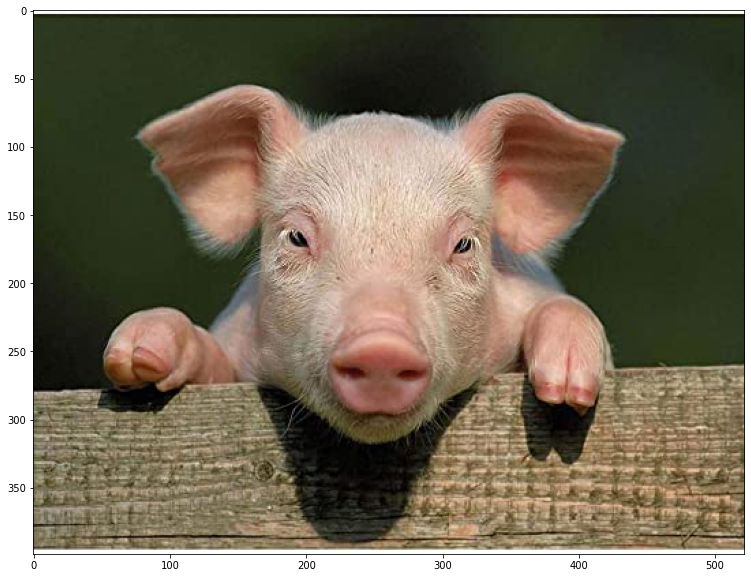

In [26]:
!wget https://images-na.ssl-images-amazon.com/images/I/61q9XfIJa5L._AC_SX522_.jpg -O input.jpg
im = cv2.imread("./input.jpg")
plt.figure(figsize=(20,10))
plt.imshow(im[:,:,::-1])

# 程式流程
* 宣告設定檔物件
* 取得設定檔，指定需要的模型種類
* 設定辨識值的門檻
* 下載模型
* 宣告偵測器，並且進行偵測
* 展示類別代碼及標記值
* 利用內建Visualizer將偵測出的圖形顯示出來

In [27]:
# Inference with a object detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# If your detectron2's version is not the most updated, please use direct link as followed, to get the link , please visit 
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"

predictor = DefaultPredictor(cfg)
outputs = predictor(im)


In [28]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([16], device='cuda:0')
Boxes(tensor([[ 60.9215,  47.5144, 433.8861, 368.1377]], device='cuda:0'))


In [29]:
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
preds

['dog']

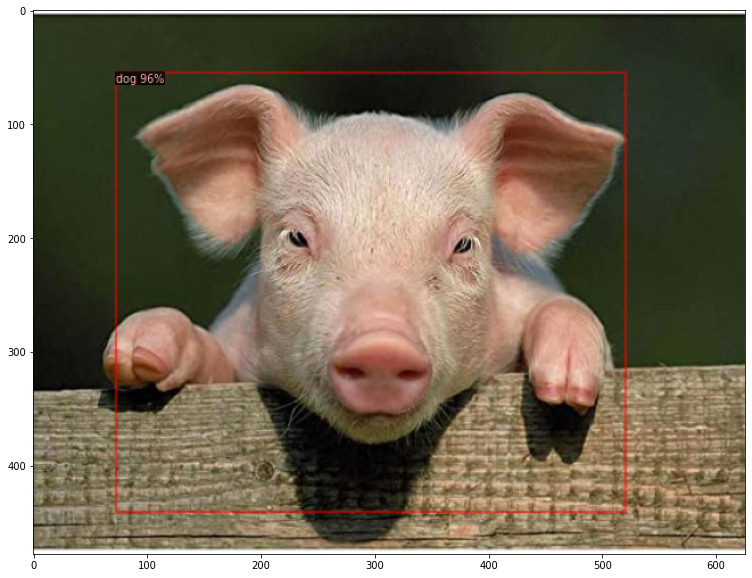

In [30]:
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

['dog']


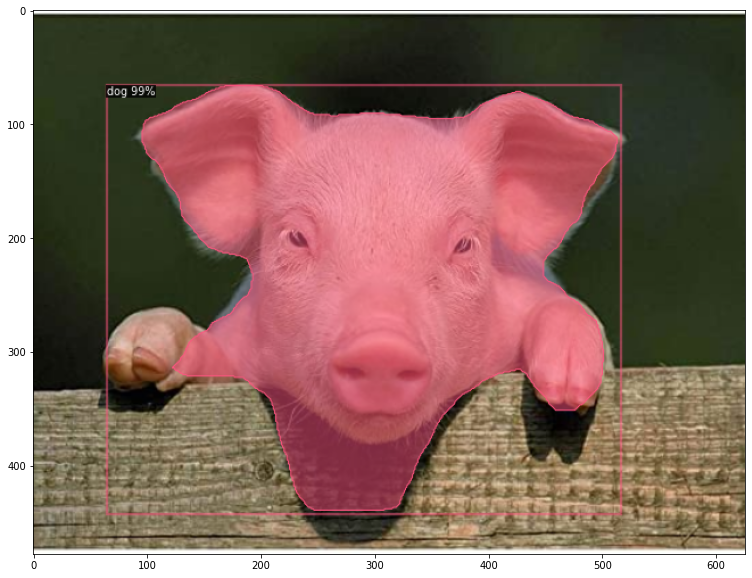

In [31]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = './model_final_f10217.pkl'
predictor = DefaultPredictor(cfg)
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
print(preds)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

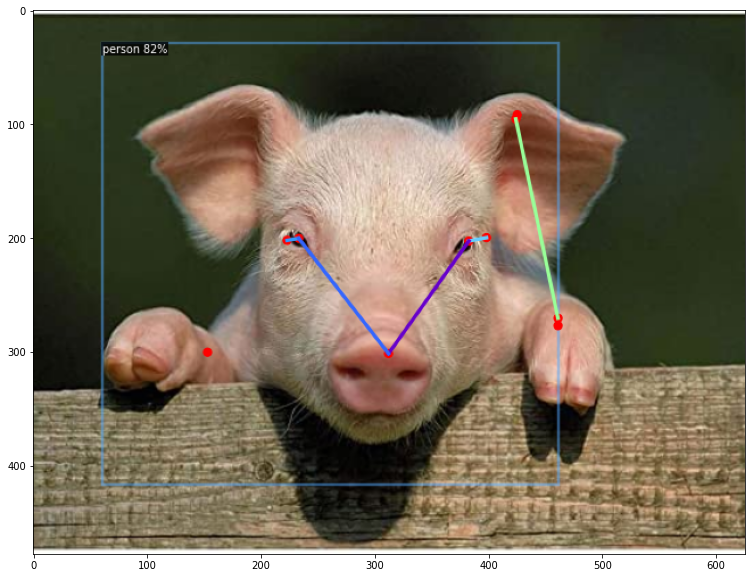

In [32]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

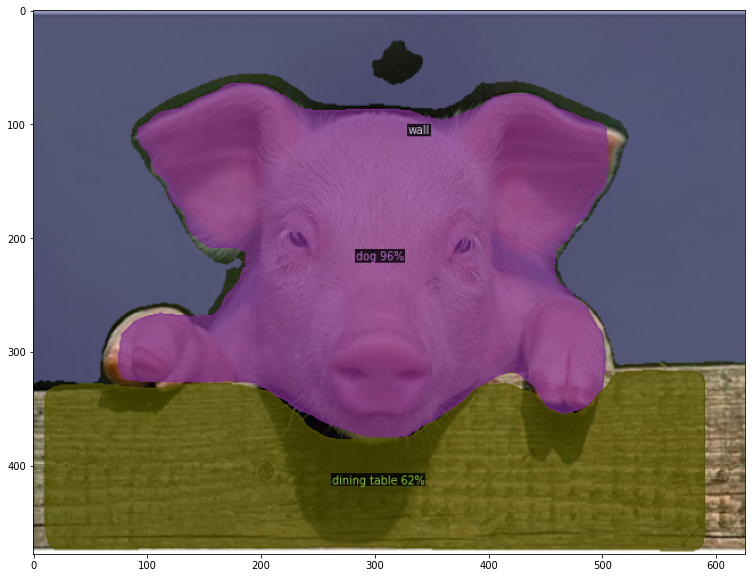

In [33]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())